In [2]:
pip install tensorflow==1.14.0

     |████████████████████████████████| 109.2MB 95kB/s 
     |████████████████████████████████| 491kB 47.8MB/s 
     |████████████████████████████████| 51kB 8.2MB/s 
     |████████████████████████████████| 3.2MB 49.1MB/s 
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1


In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/My Drive/IP_project/

/content/drive/My Drive/IP_project


In [5]:
pip install n2v

     |████████████████████████████████| 51kB 4.8MB/s 
     |████████████████████████████████| 112kB 11.4MB/s 
     |████████████████████████████████| 17.9MB 210kB/s 
     |████████████████████████████████| 71kB 11.9MB/s 
     |████████████████████████████████| 337kB 60.4MB/s 
     |████████████████████████████████| 552kB 54.6MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [6]:
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import urllib
import os
import zipfile
from tifffile import imread
from csbdeep.io import save_tiff_imagej_compatible

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [7]:
# create a folder for our data
if not os.path.isdir('./data'):
    os.mkdir('data')

# check if data has been downloaded already
zipPath="data/BSD68_reproducibility.zip"
if not os.path.exists(zipPath):
    #download and unzip data
    data = urllib.request.urlretrieve('https://cloud.mpi-cbg.de/index.php/s/pbj89sV6n6SyM29/download', zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall("data")

In [8]:
X = np.load('data/BSD68_reproducibility_data/train/DCNN400_train_gaussian25.npy')
X_val = np.load('data/BSD68_reproducibility_data/val/DCNN400_validation_gaussian25.npy')


print(X.shape)
print(X_val.shape)

# Adding channel dimension
X = X[..., np.newaxis]
print(X.shape)
X_val = X_val[..., np.newaxis]
print(X_val.shape)

(3168, 180, 180)
(4, 180, 180)
(3168, 180, 180, 1)
(4, 180, 180, 1)


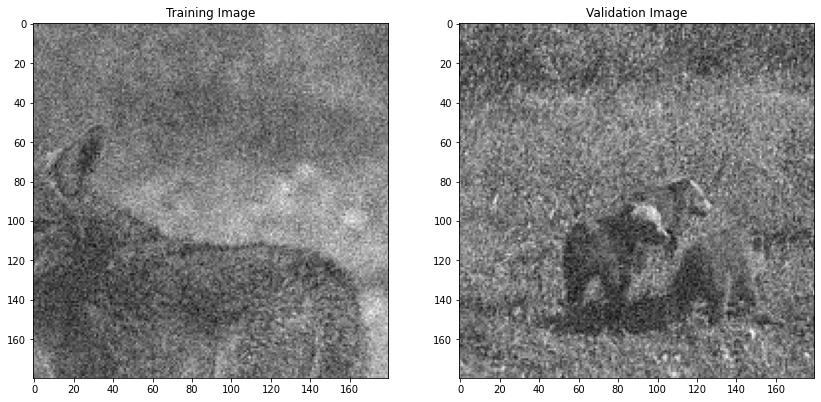

In [9]:
# Let's look at one of our training and validation patches.
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(X[0,...,0], cmap='gray')
plt.title('Training Image');
plt.subplot(1,2,2)
plt.imshow(X_val[0,...,0], cmap='gray')
plt.title('Validation Image');

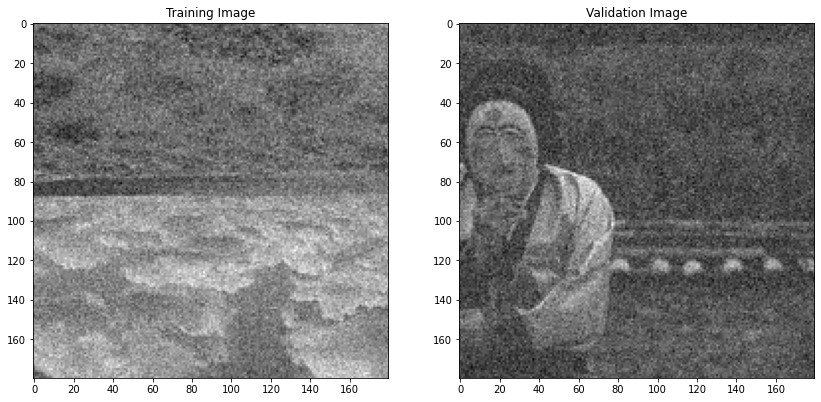

In [10]:
# Let's look at one of our training and validation patches.
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(X[1,...,0], cmap='gray')
plt.title('Training Image');
plt.subplot(1,2,2)
plt.imshow(X_val[1,...,0], cmap='gray')
plt.title('Validation Image');

In [1]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [16]:
#shape of first training image for example
print(X[0].shape)
print(X.shape)
# So we have 3160 training patches

(180, 180, 1)
(3168, 180, 180, 1)


#Defining training parameters and network architecture using N2VConfig object

In [17]:
#datagen = N2V_DataGenerator()

#X = datagen.generate_patches_from_list(X[0], shape=(96,96))
'''

We pick parameter train_steps_per_epoch equal to (num of all training patches)/(train_batch_size) = 3168/128 = 25

train_steps_per_epoch is number of batches(of input patches) that will be seen by network in each epoch


'''


my_configs = N2VConfig(X, unet_kern_size=3, 
                   train_steps_per_epoch=25, train_epochs=100, train_loss='mse', batch_norm=True, 
                   train_batch_size=128, n2v_perc_pix=1.5, n2v_patch_shape=(64, 64), 
                   unet_n_first = 96,
                   unet_residual = True,
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5,
                   single_net_per_channel=False)

# Let's look at the parameters stored in the config-object.
vars(my_configs)





{'axes': 'YXC',
 'batch_norm': True,
 'means': ['110.72957232412905'],
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'n2v_patch_shape': (64, 64),
 'n2v_perc_pix': 1.5,
 'n_channel_in': 1,
 'n_channel_out': 1,
 'n_dim': 2,
 'probabilistic': False,
 'single_net_per_channel': False,
 'stds': ['63.656060106500874'],
 'structN2Vmask': None,
 'train_batch_size': 128,
 'train_checkpoint': 'weights_best.h5',
 'train_epochs': 100,
 'train_learning_rate': 0.0004,
 'train_loss': 'mse',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'train_steps_per_epoch': 25,
 'train_tensorboard': True,
 'unet_input_shape': (None, None, 1),
 'unet_kern_size': 3,
 'unet_last_activation': 'linear',
 'unet_n_depth': 2,
 'unet_n_first': 96,
 'unet_residual': True}

#setting up our model for training

In [18]:
model_name = 'myN2V_for_BSD68'

basedir = 'gdrive/My Drive/IP_project/N2V_trained_model'

model = N2V(my_configs, model_name, basedir=basedir)

model.prepare_for_training(metrics=())

#Training phase

In [19]:
history = model.train(X, X_val, 10, 20)

/usr/local/lib/python3.6/dist-packages/n2v/models/n2v_standard.py:188: UserWarning: small number of validation images (only 0.1% of all images)
  warnings.warn("small number of validation images (only %.1f%% of all images)" % (100*frac_val))
Preparing validation data: 100%|██████████| 4/4 [00:00<00:00, 46.32it/s]

61 blind-spots will be generated per training patch of size (64, 64).


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




Epoch 1/10
20/20 [==============================] - 1178s 59s/step - loss: 0.5231 - val_loss: 0.6543
Epoch 2/10
20/20 [==============================] - 1186s 59s/step - loss: 0.2433 - val_loss: 0.3860
Epoch 3/10
20/20 [==============================] - 1198s 60s/step - loss: 0.2277 - val_loss: 0.2845
Epoch 4/10
20/20 [==============================] - 1124s 56s/step - loss: 0.2214 - val_loss: 0.2524
Epoch 5/10
20/20 [==============================] - 1110s 55s/step - loss: 0.2207 - val_loss: 0.2425
Epoch 6/10
20/20 [==============================] - 1103s 55s/step - loss: 0.2171 - val_loss: 0.2365
Epoch 7/10
20/20 [=========

#Plotting

['loss', 'lr', 'val_loss']


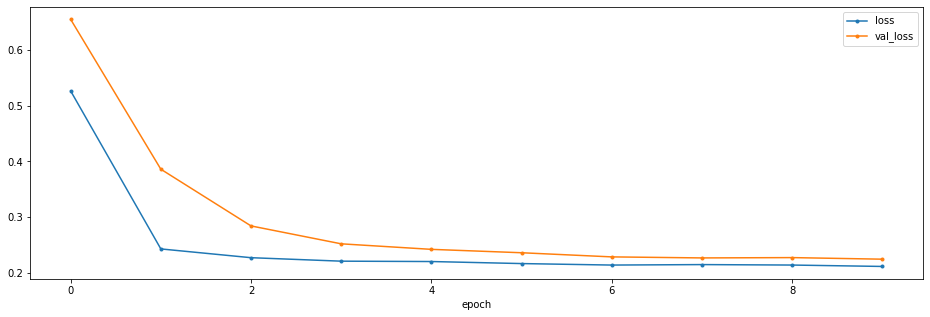

In [22]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

#Evaluating our denoising model by using PSNR value with respect to clean data

In [24]:
clean_data = np.load('data/BSD68_reproducibility_data/test/bsd68_groundtruth.npy', allow_pickle=True)


In [25]:
test_data = np.load('data/BSD68_reproducibility_data/test/bsd68_gaussian25.npy', allow_pickle=True)


In [26]:
def compute_PSNR(clean, denoised):
    mean_squared_error = np.mean(np.square(clean - denoised))
    return 20 * np.log10(255) - 10 * np.log10(mean_squared_error)

In [27]:
model.load_weights('weights_best.h5')


In [28]:
model_predictions = []
psnrs = []
for clean, test_image in zip(clean_data, test_data):
    predicted = model.predict(test_image.astype(np.float32), 'YX');
    model_predictions.append(predicted)
    psnrs.append(compute_PSNR(clean, predicted))

psnrs = np.array(psnrs)

In [29]:
print("PSNR:", np.round(np.mean(psnrs), 2))


PSNR: 24.94


#Visualizing some sample noisy images vs model predictions

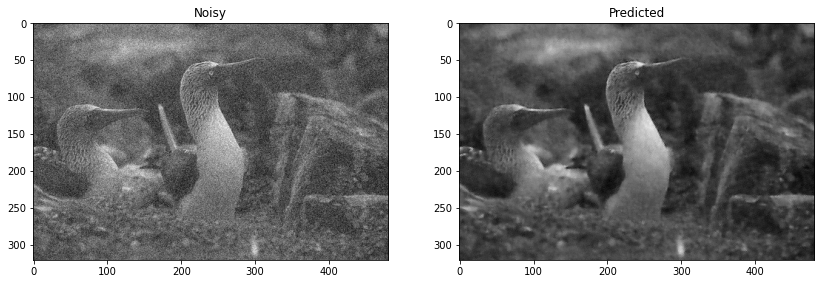

In [36]:

#plt.imshow(model_predictions[0], cmap='gray')


plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(test_data[0], cmap='gray')
plt.title('Noisy');


plt.subplot(1,2,2)
plt.imshow(model_predictions[0], cmap='gray')
plt.title('Predicted');


